In [52]:
#!pip install scikit-plot

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [54]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

In [55]:
df_train = pd.read_csv('train_nolog.csv')

In [56]:
df_train['titleType'].unique()

array(['tvEpisode', 'videoGame', 'movie', 'tvSeries', 'tvMiniSeries',
       'short', 'tvMovie', 'tvSpecial', 'video', 'tvShort'], dtype=object)

In [57]:
# Mappa di raggruppamento
category_mapping = {
    'movie': 'Film',
    'tvMovie': 'Film',
    'short': 'Shorts',
    'tvShort': 'Shorts',
    'tvSeries': 'Serie TV',
    'tvMiniSeries': 'Serie TV',
    'tvEpisode': 'Serie TV',
    'tvSpecial': 'Speciale TV',
    'video': 'Video',
    'videoGame': 'Videogame'
}

# Applicare la mappa al dataframe
df_train['titleType'] = df_train['titleType'].map(category_mapping)


In [58]:
df_train['titleType'].unique()

array(['Serie TV', 'Videogame', 'Film', 'Shorts', 'Speciale TV', 'Video'],
      dtype=object)

tvEpisode    40.220651    MIN 1   MAX 249
videoGame    28.000000    MIN 16  MAX 40
movie        92.740797    MIN 15  MAX 570
tvSeries     50.222818    MIN 1   MAX 540
tvMiniSerie  124.090909   MIN 2   MAX 528
short        13.493827    MIN 0   MAX 44
tvMovie      81.049822    MIN 21  MAX 249
tvSpecial    82.533784    MIN 9   MAX 420
video        71.577778    MIN 1   MAX 384
tvShort      9.3750000    MIN 2   MAX 20

In [59]:
del df_train['originalTitle']
del df_train['rating']
del df_train['genres']
del df_train['countryOfOrigin']
del df_train['isAdult']
del df_train['canHaveEpisodes']

In [60]:
''' Solo se si vogliono usare i generi come etichette
# Dividere i generi in liste
df_train['genres'] = df_train['genres'].str.split(',')

# Espandere i generi in righe separate (es. da Movie1 -> Action|Comedy a Movie1 -> Action, Movie1 -> Comedy )
df_train = df_train.explode('genres').reset_index(drop=True)
'''

" Solo se si vogliono usare i generi come etichette\n# Dividere i generi in liste\ndf_train['genres'] = df_train['genres'].str.split(',')\n\n# Espandere i generi in righe separate (es. da Movie1 -> Action|Comedy a Movie1 -> Action, Movie1 -> Comedy )\ndf_train = df_train.explode('genres').reset_index(drop=True)\n"

In [61]:
X_train = df_train.drop(columns=['titleType'])
y_train = df_train['titleType']

DIVIDIAMO ULTERIORMENTE TRAIN (GENERIC) IN TRAIN (FOR VALIDATION) E VALIDATION

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X_trainv, X_val, y_trainv, y_val = train_test_split(
    X_train, y_train, test_size=0.4, random_state=0, stratify=y_train
)

### Normalization

In [64]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [65]:
norm = MinMaxScaler()
norm.fit(X_trainv)

X_trainv_norm = norm.transform(X_trainv)
X_val_norm = norm.transform(X_val)

# KNN

Risultati grid search: {METRIC: 'cityblock', K: np.int64(13), WEIGHTS: 'distance'} -> 0.8439560439560441

In [66]:
from sklearn.neighbors import KNeighborsClassifier

In [67]:
X_trainv_norm.shape

(9555, 11)

In [68]:
k_for_knn = 13
metric="cityblock"
weights="distance"

In [69]:
clf = KNeighborsClassifier(n_neighbors=k_for_knn, metric=metric, weights=weights)
clf.fit(X_trainv_norm, y_trainv)

KNeighborsClassifier(metric='cityblock', n_neighbors=13, weights='distance')

In [70]:
#predizione dei valori
y_val_pred = clf.predict(X_val_norm)
y_val_pred

array(['Film', 'Video', 'Film', ..., 'Film', 'Film', 'Serie TV'],
      dtype=object)

In [71]:
print("Accuracy:", accuracy_score(y_val, y_val_pred))

Accuracy: 0.847723704866562


In [72]:
# score: Return the mean accuracy on the given test data and labels.
clf.score(X_val_norm, y_val)

0.847723704866562

In [73]:
# Sarebbe la f-measure (controlla la tabella nelle notes)
print("F1:", f1_score(y_val, y_val_pred, average="macro"))
print("F1:", f1_score(y_val, y_val_pred, average="micro"))
print("F1:", f1_score(y_val, y_val_pred, labels=[1], average="micro"))
print("F1:", f1_score(y_val, y_val_pred, labels=[1], average="macro"))

F1: 0.5434575131120225
F1: 0.847723704866562
F1: 0.0
F1: 0.0


C:\Users\alban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

        Film       0.88      0.90      0.89      2456
    Serie TV       0.82      0.91      0.86      2473
      Shorts       0.88      0.84      0.86       988
 Speciale TV       0.00      0.00      0.00        59
       Video       0.57      0.28      0.38       306
   Videogame       0.60      0.17      0.27        88

    accuracy                           0.85      6370
   macro avg       0.63      0.52      0.54      6370
weighted avg       0.83      0.85      0.84      6370



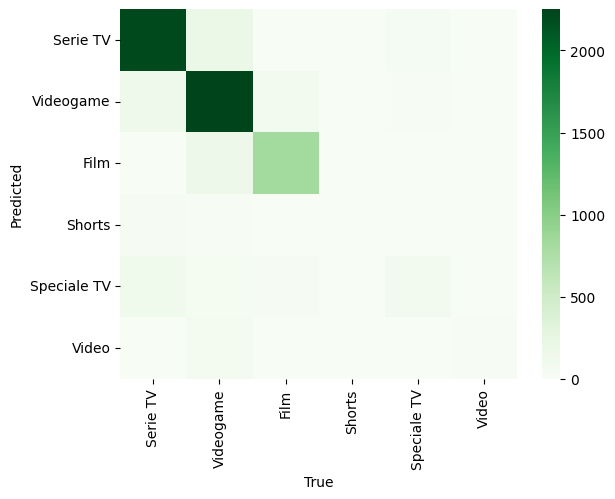

In [75]:
cf = confusion_matrix(y_val, y_val_pred)

class_names = df_train['titleType'].unique()

sns.heatmap(cf, annot=False, cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

## ROC e Precision-Recall Curve

In [76]:
# Return probability estimates for the test data X.
y_val_pred_proba = clf.predict_proba(X_val_norm)
y_val_pred_proba[0:10]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.10668941, 0.        , 0.        , 0.        , 0.89331059,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.39805259, 0.60194741, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.4270896 , 0.51359608, 0.        , 0.05931432, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.31154795, 0.15334472, 0.        , 0.        , 0.53510733,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [77]:
# Ora, visto che le label sono più di 2, possiamo solo fare una ROC curve per ogni label vs the rest, con il metodo one-vs-the rest

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize


In [78]:
# Classi uniche nel dataset
classes = np.unique(y_val)

# Binarizza y_val
y_val_binarized = label_binarize(y_val, classes=classes)

y_val_binarized


array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

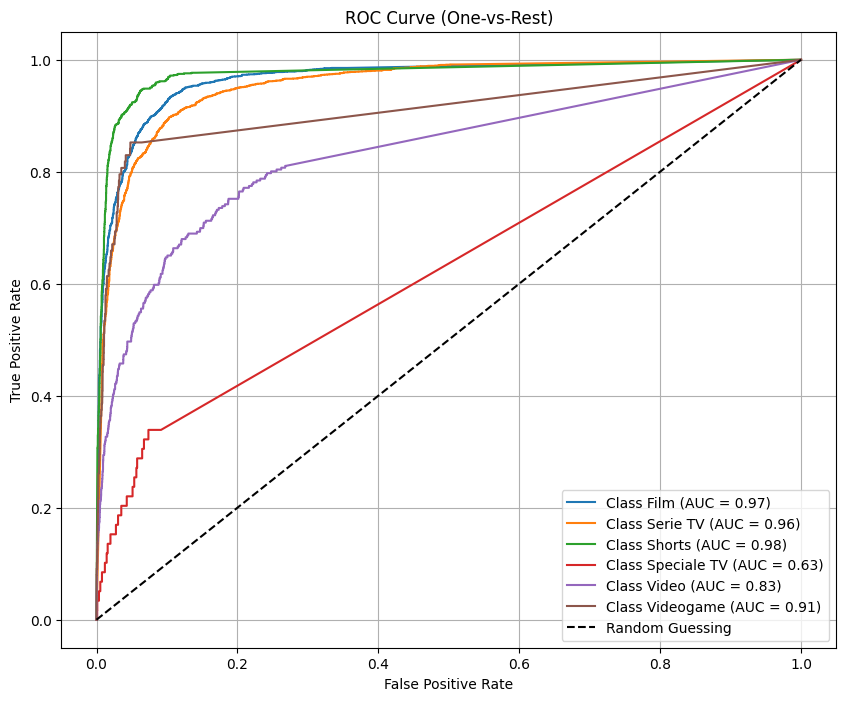

In [79]:
plt.figure(figsize=(10, 8))

for i, class_label in enumerate(classes):
    # ROC curve per la classe i
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_val_pred_proba[:, i])
    auc = roc_auc_score(y_val_binarized[:, i], y_val_pred_proba[:, i])
    
    # Traccia la curva ROC
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc:.2f})")

# Linea casuale per riferimento
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

# Personalizza il grafico
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="best")
plt.grid()
plt.show()


In [80]:
# AUC (AREA UNDER THE CURVE, Ti dice quanto bene il modello riesce a distinguere tra le classi.) 
# media di tutte le classi (le singole sono gia nel grafico)
roc_auc_score(y_val_binarized, y_val_pred_proba, multi_class="ovr", average="macro")

np.float64(0.8783802148796288)

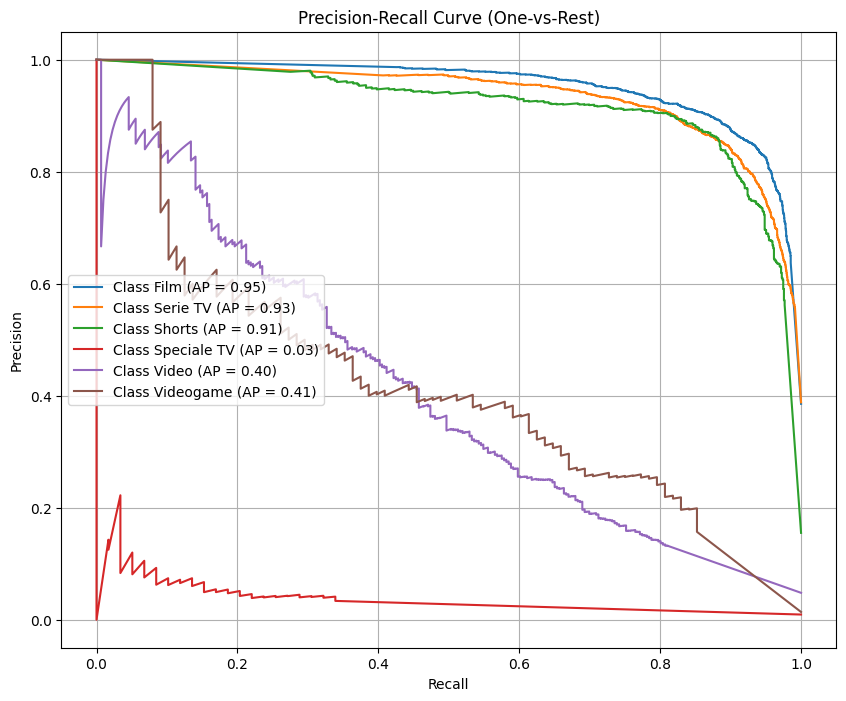

In [81]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))

for i, class_label in enumerate(classes):
    # Precision-Recall curve per la classe i
    precision, recall, _ = precision_recall_curve(y_val_binarized[:, i], y_val_pred_proba[:, i])
    ap = average_precision_score(y_val_binarized[:, i], y_val_pred_proba[:, i])
    
    # Traccia la curva Precision-Recall
    plt.plot(recall, precision, label=f"Class {class_label} (AP = {ap:.2f})")

# Personalizza il grafico
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (One-vs-Rest)")
plt.legend(loc="best")
plt.grid()
plt.show()

## Repeated Holdout

In [82]:
N = 50
err = 0

for i in range(N):
    # stratified holdout
    X_rh_trainv, X_rh_val, y_rh_trainv, y_rh_val = train_test_split(X_train, y_train, test_size=0.4, stratify=y_train)
    
    # normalize train set
    norm.fit(X_rh_trainv)
    X_rh_trainv_norm = norm.transform(X_rh_trainv)
    X_rh_val_norm = norm.transform(X_rh_val)

    # initialize and fit classifier
    clf = KNeighborsClassifier(n_neighbors=k_for_knn, metric=metric, weights=weights)
    clf.fit(X_rh_trainv_norm, y_rh_trainv)

    # computing error
    acc = clf.score(X_rh_val_norm, y_rh_val)
    err += 1 - acc

print("Overall error estimate:", err/N)

Overall error estimate: 0.15316169544740976


## Cross Validation

In [83]:
from sklearn.model_selection import cross_val_score
k = 10

In [84]:
scores = cross_val_score(clf, X_trainv_norm, y_trainv, cv=k)
scores

array([0.83891213, 0.85146444, 0.84100418, 0.83786611, 0.84832636,
       0.8460733 , 0.84502618, 0.83560209, 0.83350785, 0.86282723])

In [85]:
print("Overall error estimate:", 1 - scores.mean())

Overall error estimate: 0.15593901290280188


In [86]:
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std()))

Accuracy: 0.8441 (+/- 0.01)


## Hyperparameters Tuning

ValueError: The number of FixedLocator locations (23), usually from a call to set_ticks, does not match the number of labels (115).

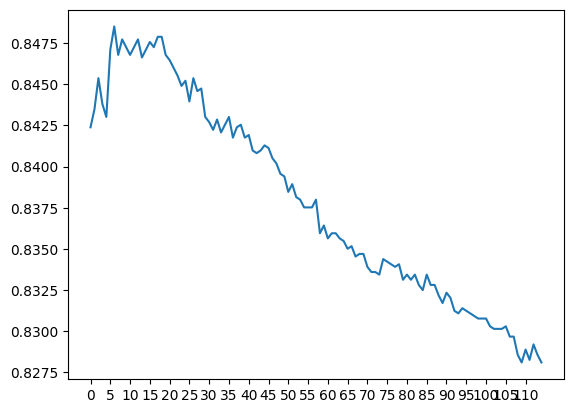

In [87]:
n_neighbors = range(5,120)
scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric=metric, weights=weights)
    clf.fit(X_trainv_norm, y_trainv)
    scores.append(clf.score(X_val_norm, y_val))

x_ticks = list(range(0, len(n_neighbors), 5))
plt.plot(scores)
plt.xticks(ticks=x_ticks, labels=n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of labels (115).

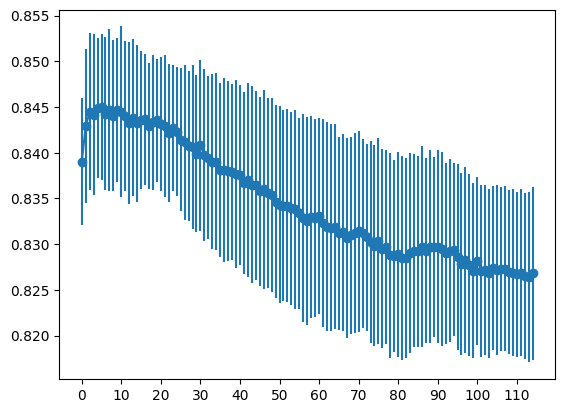

In [88]:
n_neighbors = range(5,120)
avg_scores = list()
std_scores = list()
k = 10

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric=metric, weights=weights)
    scores = cross_val_score(clf, X_trainv_norm, y_trainv, cv=k)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

#plt.plot(avg_scores)
x_ticks = list(range(0, len(n_neighbors), 10))
plt.errorbar(range(len(n_neighbors)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(ticks=x_ticks, labels=n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

## Grid search

In [179]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [180]:
'''
%%time


param_grid = {
    "n_neighbors": np.arange(5, 120),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    # verbose=2
)

grid.fit(X_trainv_norm, y_trainv)
clf = grid.best_estimator_
'''

In [181]:
'''print(grid.best_params_, grid.best_score_)

{'metric': 'cityblock', 'n_neighbors': np.int64(13), 'weights': 'distance'} 0.8439560439560441


In [182]:
'''
y_val_pred = clf.predict(X_val_norm)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
'''

Accuracy: 0.847723704866562


In [ ]:
'''
results = pd.DataFrame(grid.cv_results_)
results
'''

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,...,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047318,0.005000,0.282813,0.019787,euclidean,5,uniform,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.835165,0.829932,...,0.834118,0.823653,0.835165,0.832025,0.825222,0.837258,0.833595,0.832098,0.005754,98
1,0.049574,0.007385,0.131389,0.018831,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.830979,0.829932,...,0.823653,0.826269,0.840398,0.829409,0.827316,0.825746,0.835165,0.829817,0.005717,128
2,0.049923,0.007075,0.287066,0.026337,euclidean,6,uniform,"{'metric': 'euclidean', 'n_neighbors': 6, 'wei...",0.838305,0.821559,...,0.826792,0.819990,0.833072,0.827839,0.818943,0.839351,0.832548,0.829063,0.006187,143
3,0.044183,0.002560,0.115631,0.011561,euclidean,6,distance,"{'metric': 'euclidean', 'n_neighbors': 6, 'wei...",0.839351,0.830455,...,0.830979,0.824699,0.840921,0.835165,0.828362,0.829409,0.834642,0.832130,0.005777,97
4,0.047136,0.004081,0.261462,0.014383,euclidean,7,uniform,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei...",0.838305,0.828885,...,0.832025,0.821036,0.828885,0.829409,0.814757,0.838828,0.830979,0.830686,0.006040,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,0.061224,0.013822,0.460471,0.059002,cityblock,117,distance,"{'metric': 'cityblock', 'n_neighbors': 117, 'w...",0.825746,0.826792,...,0.828362,0.819990,0.829409,0.826792,0.811617,0.838305,0.813187,0.825631,0.006264,207
456,0.060101,0.008459,0.614475,0.049093,cityblock,118,uniform,"{'metric': 'cityblock', 'n_neighbors': 118, 'w...",0.811617,0.815803,...,0.814757,0.806907,0.816850,0.813187,0.796965,0.826269,0.800105,0.811722,0.006878,380
457,0.056873,0.005986,0.428397,0.029078,cityblock,118,distance,"{'metric': 'cityblock', 'n_neighbors': 118, 'w...",0.825746,0.825746,...,0.827839,0.818420,0.830455,0.825222,0.812140,0.838828,0.812664,0.825641,0.006334,206
458,0.062786,0.016062,0.645683,0.066182,cityblock,119,uniform,"{'metric': 'cityblock', 'n_neighbors': 119, 'w...",0.811094,0.814757,...,0.814233,0.806384,0.816327,0.811617,0.794872,0.827316,0.801675,0.811470,0.006766,387


### Metriche utilizzate

In [187]:
'''results["metric_weight"] = results["param_metric"] + ", " + results["param_weights"]

<Axes: xlabel='param_n_neighbors', ylabel='mean_test_score'>

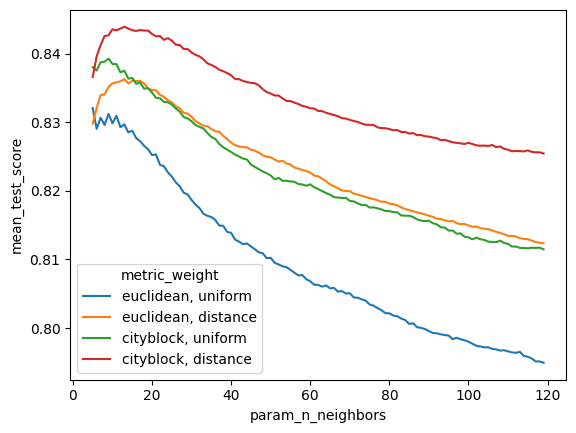

In [ ]:
'''sns.lineplot(
    data=results, x="param_n_neighbors", y="mean_test_score", hue="metric_weight"
)

## Learning curve

# VALIDATION COMPLETATA ✔

# APPLICAZIONE (k_for_knn)-NN CON TUTTI I DATI DEL TRAIN SUL TEST

In [110]:
df_test = pd.read_csv('test_nolog.csv')

In [111]:
df_test['titleType'].unique()

array(['video', 'movie', 'tvSpecial', 'tvEpisode', 'tvSeries', 'tvMovie',
       'short', 'videoGame', 'tvMiniSeries', 'tvShort'], dtype=object)

In [112]:
# Mappa di raggruppamento
category_mapping = {
    'movie': 'Film',
    'tvMovie': 'Film',
    'short': 'Shorts',
    'tvShort': 'Shorts',
    'tvSeries': 'Serie TV',
    'tvMiniSeries': 'Serie TV',
    'tvEpisode': 'Serie TV',
    'tvSpecial': 'Speciale TV',
    'video': 'Video',
    'videoGame': 'Videogame'
}

# Applicare la mappa al dataframe
df_test['titleType'] = df_test['titleType'].map(category_mapping)

In [113]:
df_test['titleType'].unique()

array(['Video', 'Film', 'Speciale TV', 'Serie TV', 'Shorts', 'Videogame'],
      dtype=object)

In [114]:
del df_test['originalTitle']
del df_test['rating']
del df_test['genres']
del df_test['countryOfOrigin']
del df_test['isAdult']
del df_test['canHaveEpisodes']

In [115]:
X_test = df_test.drop(columns=['titleType'])
y_test = df_test['titleType']

In [116]:
norm = MinMaxScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [118]:
from sklearn.model_selection import learning_curve

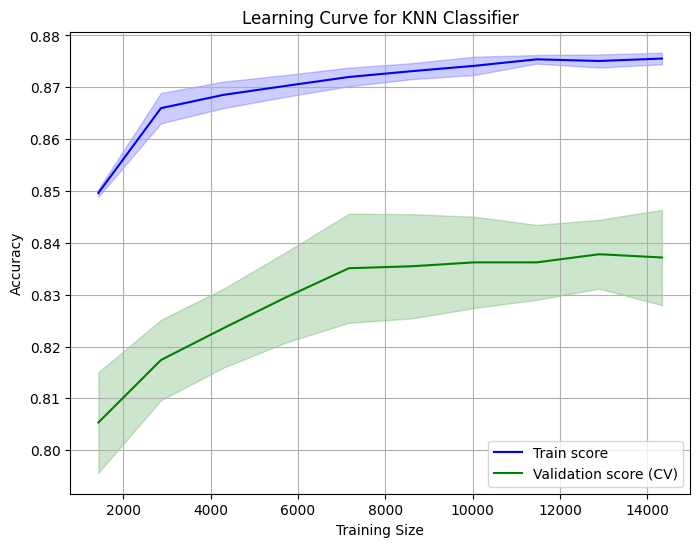

In [119]:
model = KNeighborsClassifier()
k = 10

# Calcola la learning curve con cross-validation
train_sizes, train_scores, test_scores = learning_curve(model, X_train_norm, y_train, cv=k, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calcola le medie e le deviazioni standard per train e test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Traccia la learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Train score", color='blue')
plt.plot(train_sizes, test_mean, label="Validation score (CV)", color='green')

# Aggiungi bande di deviazione standard
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

# Etichette e titolo
plt.title("Learning Curve for KNN Classifier")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Mostra il grafico
plt.show()

In [ ]:
clf = KNeighborsClassifier(n_neighbors=k_for_knn, metric=metric, weights=weights)
clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=13, weights='distance')

In [99]:
y_test_pred = clf.predict(X_test_norm)
y_test_pred

array(['Shorts', 'Film', 'Film', ..., 'Film', 'Serie TV', 'Serie TV'],
      dtype=object)

In [100]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.8496903734284106


In [101]:
clf.score(X_test_norm, y_test)

0.8496903734284106

In [102]:
print("F1:", f1_score(y_test, y_test_pred, average="macro"))
print("F1:", f1_score(y_test, y_test_pred, average="micro"))
print("F1:", f1_score(y_test, y_test_pred, labels=[1], average="micro"))
print("F1:", f1_score(y_test, y_test_pred, labels=[1], average="macro"))

F1: 0.4971921307259963
F1: 0.8496903734284106
F1: 0.0
F1: 0.0


C:\Users\alban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [103]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

        Film       0.85      0.92      0.88      2094
    Serie TV       0.87      0.90      0.88      2094
      Shorts       0.86      0.84      0.85       770
 Speciale TV       0.00      0.00      0.00        46
       Video       0.50      0.29      0.36       242
   Videogame       0.00      0.00      0.00        83

    accuracy                           0.85      5329
   macro avg       0.51      0.49      0.50      5329
weighted avg       0.82      0.85      0.83      5329



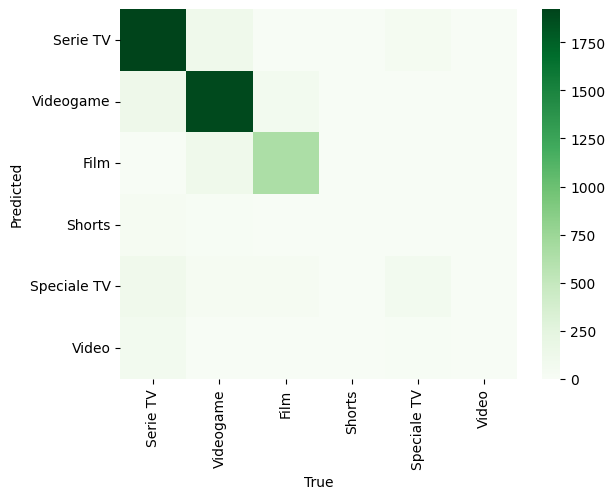

In [104]:
cf = confusion_matrix(y_test, y_test_pred)

class_names = df_train['titleType'].unique()

sns.heatmap(cf, annot=False, cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [105]:
y_test_pred_proba = clf.predict_proba(X_test_norm)
y_test_pred_proba[0:10]

array([[0.        , 0.17848341, 0.82151659, 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.86229091, 0.13770909, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.50771531, 0.24904349, 0.        , 0.        , 0.2432412 ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.91272515, 0.08727485, 0.        , 0.        ,
        0.        ],
       [0.77950781, 0.22049219, 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.83005472, 0.12503247, 0.        , 0.        , 0.04491281,
        0.        ]])

In [106]:
classes = np.unique(y_test)

# Binarizza Y_test
y_test_binarized = label_binarize(y_test, classes=classes)

y_test_binarized

array([[0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

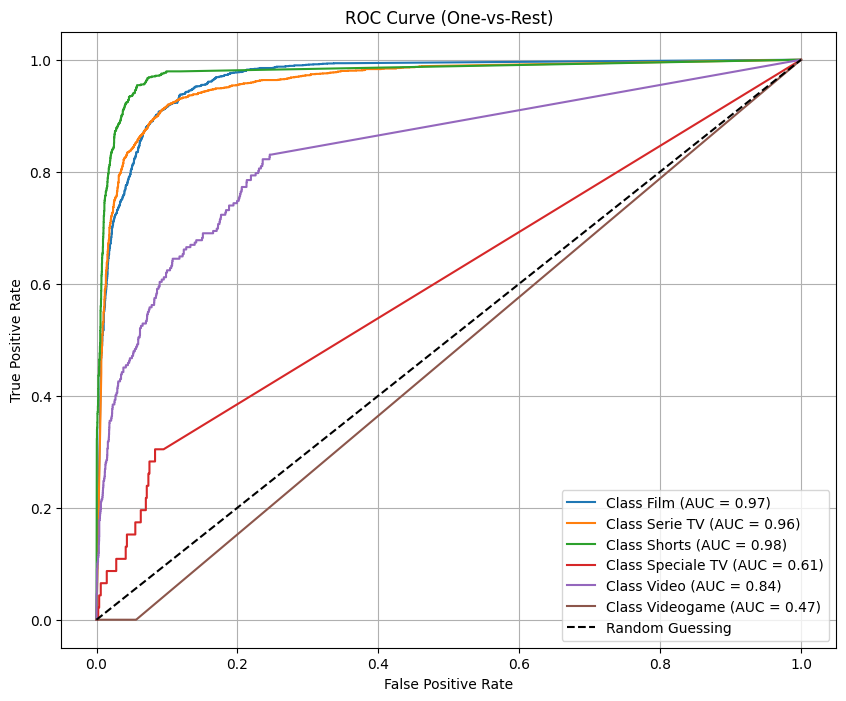

In [107]:
plt.figure(figsize=(10, 8))

for i, class_label in enumerate(classes):
    # ROC curve per la classe i
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], y_test_pred_proba[:, i])
    
    # Traccia la curva ROC
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc:.2f})")

# Linea casuale per riferimento
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

# Personalizza il grafico
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="best")
plt.grid()
plt.show()

In [108]:
roc_auc_score(y_test_binarized, y_test_pred_proba, multi_class="ovr", average="macro")

np.float64(0.803999903424387)

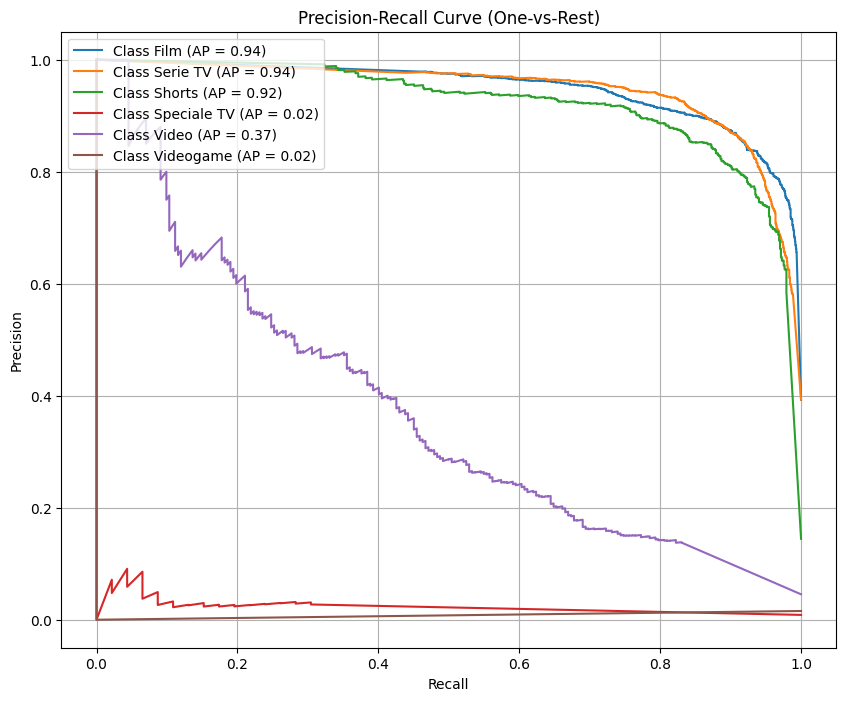

In [109]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))

for i, class_label in enumerate(classes):
    # Precision-Recall curve per la classe i
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    ap = average_precision_score(y_test_binarized[:, i], y_test_pred_proba[:, i])
    
    # Traccia la curva Precision-Recall
    plt.plot(recall, precision, label=f"Class {class_label} (AP = {ap:.2f})")

# Personalizza il grafico
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (One-vs-Rest)")
plt.legend(loc="best")
plt.grid()
plt.show()